# 🔬 MNIST Handwritten Character Recognition: A Deep Learning Project

<details>
<summary><strong>📋 About This Project & Objectives</strong></summary>

This exercise implements the MNIST handwritten character recognition, which is a typical case in the deep learning field. The whole process is as follows:

**Learning Objectives:**

- 📊 Master dataset preprocessing techniques for image recognition
- 🏛️ Build and configure neural network architectures
- ⚙️ Implement training loops and model validation
- 📈 Evaluate model performance on test data

</details>

## 📚 Imports and Environment Setup
Setting up the required libraries and environment for the project.

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

# Import related dependent libraries.
import os
from matplotlib import pyplot as plt
import numpy as np

import mindspore as ms
import mindspore.context as context
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.nn.metrics import Accuracy

from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

context.set_context(mode=context.GRAPH_MODE, device_target='CPU')

## 📁 Dataset Loading and Exploration
Processing the MNIST dataset for handwritten digit recognition.

In [2]:
# Read data.
DATA_DIR_TRAIN = "train" # Training set information
DATA_DIR_TEST = "test" # Test set information

# Load the MNIST dataset
ds_train = ds.MnistDataset(DATA_DIR_TRAIN, usage="train", shuffle=True)
ds_test = ds.MnistDataset(DATA_DIR_TEST, usage="test", shuffle=False)

# Display the dataset features.
print('Data volume of the training dataset:',ds_train.get_dataset_size())
print('Data volume of the test dataset:',ds_test.get_dataset_size())
image=ds_train.create_dict_iterator().__next__()
print('Image length/width/channels:',image['image'].shape)
print('Image label style:',image['label']) # Total 10 label classes which are represented by numbers from 0 to 9.

Data volume of the training dataset: 60000
Data volume of the test dataset: 10000
Image length/width/channels: (28, 28, 1)
Image label style: 4


In [3]:
def create_dataset(training=True, batch_size=128, resize=(28, 28),
                   rescale=1/255, shift=0, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    
    # Define data augmentation and normalization operations
    resize_op = CV.Resize(resize)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    
    # Apply transformations
    ds = ds.map(operations=resize_op, input_columns=["image"])
    ds = ds.map(operations=rescale_op, input_columns=["image"])
    ds = ds.map(operations=hwc2chw_op, input_columns=["image"])
    
    # Convert label to int32
    type_cast_op = C.TypeCast(ms.int32)
    ds = ds.map(operations=type_cast_op, input_columns=["label"])
    
    # Set the shuffle parameter and batch size
    ds = ds.shuffle(buffer_size).batch(batch_size)
    
    return ds

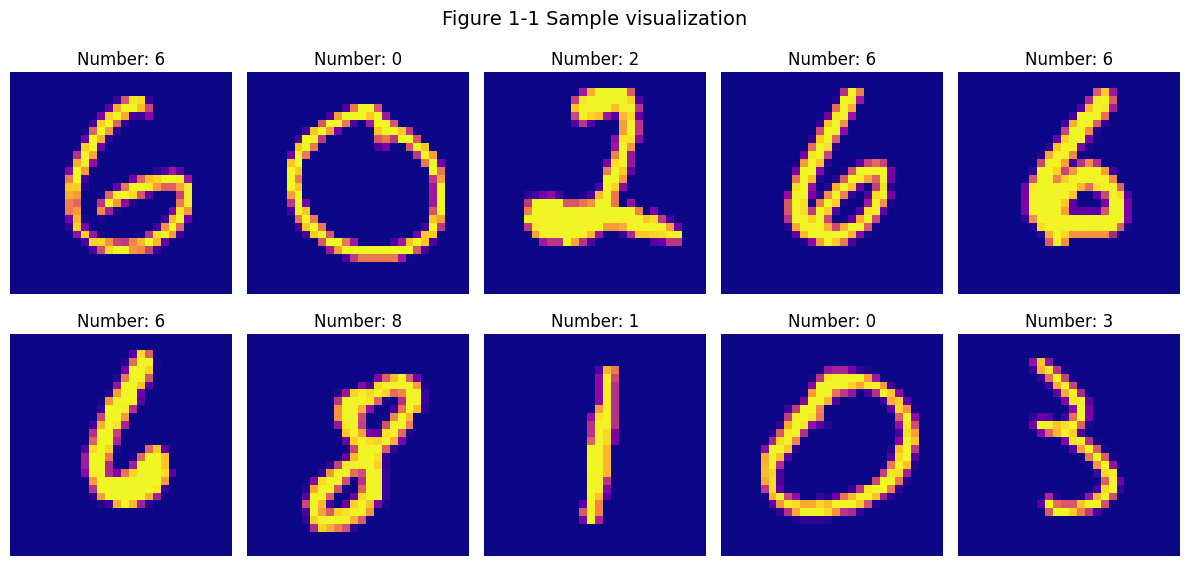

In [9]:
# Display the first 10 images and the labels, and check whether the images are correctly labeled.
plt.figure(figsize=(12, 6))

# Get first batch of data from training dataset
data_iter = ds_train.create_dict_iterator()
data = next(data_iter)
images = data['image'].asnumpy()
labels = data['label'].asnumpy()

# Display first 10 images
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='plasma')
    plt.title(f'Number: {labels[i]}')
    plt.axis('off')

plt.suptitle('Figure 1-1 Sample visualization', fontsize=14)
plt.tight_layout()
plt.show()

## 🏛️ Neural Network Architecture
Building a fully-connected network for handwritten digit classification.

In [10]:
# Create a model. The model consists of three fully connected layers. The final output layer uses 
#softmax for classification (10 classes consisting of numbers 0 to 9.)
class MNISTModel(nn.Cell):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(28 * 28, 128)
        self.fc2 = nn.Dense(128, 64)
        self.fc3 = nn.Dense(64, 10)
        self.softmax = nn.Softmax()

    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

## ⚙️ Loss Function and Optimizer Configuration
Setting up the training components for model optimization.

In [11]:
# Define loss function and optimizer
# Create a network, loss function, validation metric, and optimizer, and set related hyperparameters.
net = MNISTModel()
loss = nn.CrossEntropyLoss()
metric = Accuracy()
optimizer = nn.Adam(net.trainable_params(), learning_rate=0.001)

## 📈 Model Training
Training the neural network on the MNIST dataset.

In [12]:
# Create the model with all components
# Build a model.
model = Model(net, loss, optimizer, metrics={'accuracy': metric})

# Generate a dataset.
ds_train = create_dataset(training=True, batch_size=32)
ds_eval = create_dataset(training=False, batch_size=32)

[WARNING] ME(11874:123743177216128,MainProcess):2025-09-12-15:51:10.698.181 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(11874:123743177216128,MainProcess):2025-09-12-15:51:10.699.883 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(11874:123743177216128,MainProcess):2025-09-12-15:51:10.701.603 [mindspore/dataset/core/validator_helpers.py:744] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(11874:123743177216128,MainProcess):2025-09-12-15:51:10.702.576 [mindspore/dat

In [13]:
# Load training dataset and start training

# Configure training callbacks
time_monitor = TimeMonitor()
loss_monitor = LossMonitor(1875)  # Print loss every 1875 steps (end of epoch)

print("============== Starting Training ==============")

# Train the model
model.train(epoch=10, train_dataset=ds_train, callbacks=[time_monitor, loss_monitor])

============== Starting Training ==============
epoch: 1 step: 1875, loss is 1.7107527256011963
Train epoch time: 6203.150 ms, per step time: 3.308 ms
epoch: 1 step: 1875, loss is 1.7107527256011963
Train epoch time: 6203.150 ms, per step time: 3.308 ms
epoch: 2 step: 1875, loss is 1.4892611503601074
Train epoch time: 6562.621 ms, per step time: 3.500 ms
epoch: 2 step: 1875, loss is 1.4892611503601074
Train epoch time: 6562.621 ms, per step time: 3.500 ms
epoch: 3 step: 1875, loss is 1.4940314292907715
Train epoch time: 5694.451 ms, per step time: 3.037 ms
epoch: 3 step: 1875, loss is 1.4940314292907715
Train epoch time: 5694.451 ms, per step time: 3.037 ms
epoch: 4 step: 1875, loss is 1.491666316986084
Train epoch time: 4733.087 ms, per step time: 2.524 ms
epoch: 4 step: 1875, loss is 1.491666316986084
Train epoch time: 4733.087 ms, per step time: 2.524 ms
epoch: 5 step: 1875, loss is 1.4732897281646729
Train epoch time: 5024.644 ms, per step time: 2.680 ms
epoch: 5 step: 1875, loss i

## 🎯 Model Evaluation and Testing
Validating the trained model on the test dataset.

In [14]:
# Use the test set to validate the model and print the overall accuracy.
metrics=model.eval(ds_eval)
print(metrics)

{'accuracy': 0.9726}
